# Import the libraries that are needed

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn import preprocessing
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

TensorFlow version: 2.9.2


#initialize the train and test data set + perform the fourier transformation

In [ ]:
targetdata = np.loadtxt('verschilgeschaald.csv',dtype=float,delimiter=',') #data that we want to predict
dim_targetdata = 99 #number of values that need to be predicted per input point
modinfo = np.loadtxt('modinfo.csv',dtype=float,delimiter=',') 
alleLFs = np.loadtxt('alleLFs.csv',dtype=float,delimiter=',') 
features = []
for ii in range(len(modinfo)): 
    rij = modinfo[ii]
    toetevoegen = np.concatenate([rij, alleLFs[ii]])
    features.append(toetevoegen)
features = np.array(features) #input data for the model
dim_modinfo = 4+99 #number of input parameters per input point
train_size = 6300 #number of datapoints in the train dataset
test_size = 1000 #number of datapoints in the test dataset
dim_latent_space = 5 #dimension of the latent space representation

In [ ]:
#perform the fourier transform
verschilfour = []
for ii in range(len(targetdata)):
  verschilfour.append(sc.fft.fft(targetdata[ii]))
verschilfour = np.array(verschilfour)
#split in real and imaginary part
re = np.real(verschilfour)
im = np.imag(verschilfour)
topred = []
for ii in range(len(re)):
  tijdsding = []
  for jj in range(len(re[0])):
    elnt = [re[ii,jj],im[ii,jj]]
    tijdsding.append(elnt)
  topred.append(tijdsding)
topred = np.array(topred)

indexen = range(len(verschilfour))

#split in train and test data set
X_trainges, X_testges, indexen_trainges_final, indexen_testges_final = train_test_split(features, indexen, train_size=5000, test_size=177, random_state=333)
training_yges = topred[indexen_trainges_final]
y_testges = topred[indexen_testges_final]

Exploit symmetry of the fouriertransform

In [ ]:
redeel = (topred[:,:,0]).copy()
for ii in range(int((dim_targetdata-1)/2),dim_targetdata):
  redeel[:,ii] = topred[:,int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),0]

In [ ]:
imdeel = (topred[:,:,1]).copy()
for ii in range(int((dim_targetdata-1)/2),dim_targetdata):
  imdeel[:,ii] = -topred[:,int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),1]

# Define the fouriercomponents that will be used for the prediction

In [ ]:
relim = [5,95,99] #[x,y,z]: fouriercomponents from 0 to x and from y to z are taken into account for the real part with the last ones mirrored from the first ones
imlim = [4,96,99] #[x,y,z]: fouriercomponents from 0 to x and from y to z are taken into account for the imag part with the last ones mirrored from the first ones

In [ ]:
predfour = topred.copy()
for jj in range(len(predfour)):
  for ii in range(imlim[0],imlim[1]):
    predfour[jj][ii][1] = 0
  for ii in range(relim[0],relim[1]):
    predfour[jj][ii][0] = 0
  for ii in range(imlim[1],imlim[2]):
    predfour[jj][ii][1] = -topred[jj,np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),1]
  for ii in range(relim[1],relim[2]):
    predfour[jj][ii][0] = topred[jj,np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),0]  

Prediction based on the limited number of fourier components

In [ ]:
pred = []
for ii in range(len(predfour)):
  tijdsvector = []
  for jj in range(len(predfour[0])):
    tijdsvector.append(complex(predfour[ii,jj,0],predfour[ii,jj,1]))
  pred.append(tijdsvector)
predictie = np.real(sc.fft.ifft(pred))

# Use neural network to estimate the difference between the fourierprediction and the real values

In [ ]:
errfour = []
for ii in range(len(targetdata)):
  errfour.append(targetdata[ii]-predictie[ii])

split in train and test dataset

In [ ]:
indexenfourr = range(len(errfour))
errfour_train, errfour_test, indexen_trainges, indexen_testges = train_test_split(errfour, indexenfourr, train_size=5000, test_size=177, random_state=333)

make and train the neural network

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 99)]              0         
                                                                 
 dense (Dense)               (None, 5)                 500       
                                                                 
 dense_1 (Dense)             (None, 99)                594       
                                                                 
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
125/125 [==============================] - 1s 3ms/step - loss: 5.1903 - val_loss: 0.0011
Epoch 2/500
125/125 [==============================] - 0s 2ms/step - loss: 5.1883 - val_loss: 0.0011
Epoch 3/500
125/125 [==============================] - 0s 3ms/step - loss: 5.1864 - val_loss: 0.0011
Epoch 4/500
125/125 

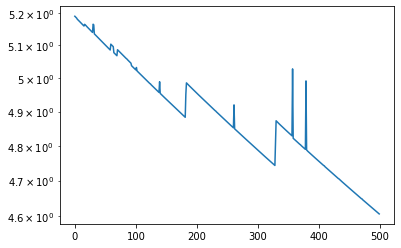

In [ ]:
X = np.array(errfour_train).reshape(len(errfour_train), dim_targetdata)
params_input = keras.Input(shape=(dim_targetdata))
encoder = tf.keras.layers.Dense(dim_latent_space,activation = 'tanh')(params_input)
decoder = tf.keras.layers.Dense(dim_targetdata)(encoder)
modelauto = keras.Model(inputs=params_input,outputs=decoder)
modelauto.compile(optimizer='adam', loss='mse')
modelauto.summary()
hist = modelauto.fit(X,X,epochs=500,validation_split=0.2,batch_size=32)
plt.semilogy(hist.history['loss'])

Prediction based on limited number of fourier components and predicted difference

In [ ]:
test_input = np.array(errfour).reshape(len(errfour), dim_targetdata)
test_output = np.array(modelauto.predict(test_input, verbose=0)) # = echt - fourier

In [ ]:
uiteindelijkeschatting = test_output + predictie

# Prediction of the parameters

In [ ]:
fourtopred = np.concatenate([predfour[:,0:5,0],predfour[:,1:4,1]],axis = 1) # 1:4 because first one is always 0
#obtain the hidden vectors
Xen = np.array(errfour).reshape(len(errfour), dim_targetdata)
layer_output = modelauto.get_layer('dense').output #dense can need an extra number, depending on how much the algorithm is performed
intermediate_model=tf.keras.models.Model(inputs=params_input,outputs=layer_output)
tussen=intermediate_model.predict(Xen) # = hidden vectors!
tevoorspellen = np.concatenate([fourtopred,tussen],axis = 1)

230/230 [==============================] - 0s 1ms/step


In [ ]:
indexen = range(len(features))
X_train_four, X_test_four, indexen_train_four, indexen_test_four = train_test_split(features, indexen, train_size=5000, test_size=177, random_state=333)
training_y_four = fourtopred[indexen_train_four]
y_test_four = fourtopred[indexen_test_four]

X = np.array(X_train_four).reshape(len(X_train_four), dim_modinfo)

Y = np.array(training_y_four).reshape(len(training_y_four), 8)
#using a standardscaler here is advised

Make and train the neural network

In [ ]:
params_input = keras.Input(shape=(dim_modinfo)) #less inputparameters can be used in this step
dense = tf.keras.layers.Dense(50,activation = 'relu')(params_input)
dense1 = tf.keras.layers.Dense(40,activation = 'relu')(dense)
dense2 = tf.keras.layers.Dense(30,activation = 'relu')(dense1)
dense3 = tf.keras.layers.Dense(15,activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(30,activation = 'relu')(dense2)
dense45 = tf.keras.layers.Dense(40,activation = 'relu')(dense4)
dense42 = tf.keras.layers.Dense(25,activation = 'relu')(dense45)
dense5 = tf.keras.layers.Dense(relim[0]+imlim[0]-1)(dense42) #-1 since '1:4 because first one is always 0'
modelfour = keras.Model(inputs=params_input,outputs=dense5)
modelfour.compile(optimizer='adam', loss='mse')
modelfour.summary()
hist = modelfour.fit(X,Y,epochs=1000,validation_split=0.2,batch_size=32) 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 103)]             0         
                                                                 
 dense_18 (Dense)            (None, 50)                5200      
                                                                 
 dense_19 (Dense)            (None, 40)                2040      
                                                                 
 dense_20 (Dense)            (None, 30)                1230      
                                                                 
 dense_22 (Dense)            (None, 30)                930       
                                                                 
 dense_23 (Dense)            (None, 40)                1240      
                                                                 
 dense_24 (Dense)            (None, 25)                1025

In [ ]:
test_input = np.array(features).reshape(len(features), dim_modinfo)
test_output = np.array(modelfour.predict(test_input, verbose=0))
fourpredictienn = np.vstack(np.transpose(np.array((test_output[:,0],test_output[:,1],test_output[:,2],test_output[:,3],test_output[:,4],np.zeros(len(test_output)),test_output[:,5],test_output[:,6],test_output[:,7]))))

##Predict the hidden state

In [ ]:
indexen = range(len(features))
feathid = []
#add the predicted fouriercomponents to the input of hiddenstate prediction
for ii in range(len(features)):
  feathid.append(np.concatenate([features[ii], fourpredictienn[ii]]))


X_train_hid, X_test_hid, indexen_train_hid, indexen_test_hid = train_test_split(feathid, indexen, train_size=5000, test_size=177, random_state=333)
training_y_hid = tussen[indexen_train_hid]
y_test_hid = tussen[indexen_test_hid]


X = np.array(X_train_hid).reshape(len(X_train_hid), dim_modinfo+relim[0]+imlim[0]) #dim = modinfo + number of fouriercomponents

Y = np.array(training_y_hid).reshape(len(training_y_hid), dim_latent_space)
#again its better to standardscale

In [ ]:
params_input = keras.Input(shape=(dim_modinfo+relim[0]+imlim[0]))
dense2 = tf.keras.layers.Dense(100,activation = 'relu')(params_input)
dense3 = tf.keras.layers.Dense(20,activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(dim_latent_space)(dense3)
modelhid = keras.Model(inputs=params_input,outputs=dense4)
modelhid.compile(optimizer='adam', loss='mse')
modelhid.summary()
hist = modelhid.fit(X,Y,epochs=100,validation_split=0.2,batch_size=32)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 112)]             0         
                                                                 
 dense_26 (Dense)            (None, 100)               11300     
                                                                 
 dense_27 (Dense)            (None, 20)                2020      
                                                                 
 dense_28 (Dense)            (None, 5)                 105       
                                                                 
Total params: 13,425
Trainable params: 13,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 1s 3ms/step - loss: 24.5943 - val_loss: 0.1440
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 35.5065 - 

In [ ]:
inputhid = np.array(feathid).reshape(len(feathid), dim_modinfo+relim[0]+imlim[0]) #dim = modinfo + number of fouriercomponents
hidpredictienn = np.array(modelhid.predict(inputhid))

230/230 [==============================] - 0s 1ms/step


# From estimated parameters back to prediction

In [ ]:
fourpred = fourpredictienn
hiddenpred = hidpredictienn

In [ ]:
allefourpredtussen = []
for jj in range(len(topred)):
  toetevoegen = np.zeros((99,2))
  for ii in range(imlim[0],imlim[1]):
    toetevoegen[ii][1] = 0
  for ii in range(relim[0],relim[1]):
    toetevoegen[ii][0] = 0
  for ii in range(0,relim[0]):
    toetevoegen[ii][0] = fourpred[jj,ii]
  for ii in range(0,imlim[0]):
    toetevoegen[ii][1] = fourpred[jj,ii+5]
  allefourpredtussen.append(toetevoegen)

allefourpred = allefourpredtussen.copy()
for jj in range(len(topred)):
  for ii in range(imlim[1],imlim[2]):
    allefourpred[jj][ii][1] = -allefourpredtussen[jj][np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii))][1]
  for ii in range(relim[1],relim[2]):
    allefourpred[jj][ii][0] = allefourpredtussen[jj][np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii))][0]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [ ]:
allefourpredcompl = []
for jj in range(len(allefourpred)):
  tijdsvector = []
  for ii in range(len(allefourpred[0])):
      tijdsvector.append(complex(allefourpred[jj][ii][0],allefourpred[jj][ii][1]))
  allefourpredcompl.append(tijdsvector)

Inverse fouriertransform

In [ ]:
tijdslijntjenafour = np.real(sc.fft.ifft(allefourpredcompl))

Adding the auto-encoder

In [ ]:
Xen = np.array(hiddenpred).reshape(len(hiddenpred), dim_latent_space)
layer_output = modelauto.get_layer('dense_1').output #last laag
layer_input = modelauto.get_layer('dense').output #first dense layer
automoduit =tf.keras.models.Model(inputs=layer_input,outputs=layer_output)
correctiepred=automoduit.predict(Xen) # = hidden vectors!

230/230 [==============================] - 0s 1ms/step


In [ ]:
finalepred = correctiepred + tijdslijntjenafour

Text(0.5, 0, 'Time')

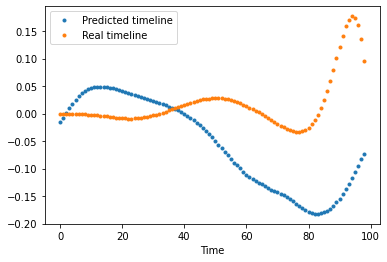

In [ ]:
plt.plot(finalepred[190],'.',label='Predicted timeline')
plt.plot(targetdata[190],'.',label='Real timeline')
plt.legend()
plt.xlabel('Time')

Text(0.5, 0, 'Depth')

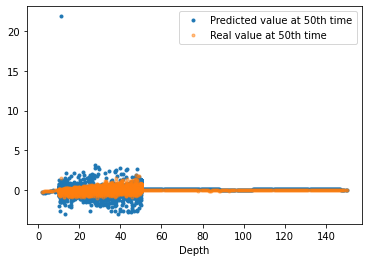

In [ ]:
plt.plot(modinfo[:,0],finalepred[:,50],'.',label='Predicted value at 50th time')
plt.plot(modinfo[:,0],targetdata[:,50],'.',alpha=0.5,label='Real value at 50th time')
plt.legend()
plt.xlabel('Depth')